In [1]:
import scipy as sp
import numpy as np
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib import rcParams
import ot

# enable latex rendering
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#rcParams['text.usetex'] = True

# color settings
X_COLOR = '#3D9140' # '#6c712d' #(191/255,255/255,191/255) #'#bfffbf0'
Y_COLOR = '#ff0000' #  #(255/255,199/255,199/255) #'#ffc7c7'
T_COLOR = '#005e7d'

PLOT_TEXT = True



# PLOTTING OF OT GRAPH #########################################################

def plot_optimal_transport_graph(xs, ys, T=None, T_title=None):
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(1,2,1)
    ax.scatter(xs[:, 0], xs[:, 1], s=600, facecolors='white', edgecolors=X_COLOR)
    ax.scatter(ys[:, 0], ys[:, 1], s=600, facecolors='white', edgecolors=Y_COLOR)
    offset_x = -0.125
    offset_y = -0.075
    for i in range(xs.shape[0]):
        if PLOT_TEXT:
            ax.text(xs[i,0]+offset_x, xs[i,1]+offset_y, '$\mathbf{x}_'+str(i+1)+'$',
                  fontsize=10, color=X_COLOR)
    for i in range(ys.shape[0]):
        if PLOT_TEXT:
            ax.text(ys[i,0]+offset_x, ys[i,1]+offset_y, '$\mathbf{y}_'+str(i+1)+'$',
                  fontsize=10, color=Y_COLOR)
    plt.axis('off')
    plt.xlim([X[:,0].min()-1.0,X[:,0].max()+1.0])
    plt.ylim([X[:,1].min()-1.0,X[:,1].max()+1.0])
    plt.gca().set_aspect('equal')
    if T is not None:
        for i in range(xs.shape[0]):
            for j in range(ys.shape[0]):
                ax.plot([xs[i,0], ys[j,0]], [xs[i,1], ys[j,1]],
                         linewidth=T[i,j]*20, zorder=-1, color=T_COLOR, linestyle='--')
    if PLOT_TEXT:
        ax.text(4.0,2.5, T_title, color=T_COLOR, fontsize=10)
    plt.show()

In [2]:
# CREATE POINTS ################################################################

xs = np.array(
  [[3.0, 5.0],
   [5, 0.2],
   [5.5, 4.0],
   [8.5, 1.5],
   [8.125, 6.0]]
)
ys = np.array(
  [[1.0, 1.0],
   [3.25, -0.1],
   [2.5, 3.0],
   [4.5, 1.5],
   [6.5, 2.0]]
)

n_xs = xs.shape[0]
n_ys = ys.shape[0]

# fix aspect ratio
xs[:,0] *= 1
ys[:,0] *= 1
xs[:,1] /= 2
ys[:,1] /= 2

X = np.concatenate((xs,ys), axis=0)

In [3]:
# OT DISTANCE COMPUTATIONS #####################################################

A = sp.spatial.distance.cdist(xs, xs, metric='euclidean')
B = sp.spatial.distance.cdist(ys, ys, metric='euclidean')

A /= A.max()
B /= B.max()

p = ot.unif(n_xs)
q = ot.unif(n_ys)

C = sp.spatial.distance.cdist(xs, ys, metric='euclidean')
T_W, log_W = ot.emd(p, q, C, log=True)

T_GW, log_GW = ot.gromov.gromov_wasserstein(A, B, p, q, 'square_loss',
                                            log=True, verbose=True)

print('Wasserstein Distance: ' + str(log_W['cost']) )
print('Gromov-Wasserstein distance: ' + str(log_GW['gw_dist']))

It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|1.773933e-01|0.000000e+00|0.000000e+00
    1|2.191276e-02|7.095437e+00|1.554806e-01
    2|2.191276e-02|0.000000e+00|0.000000e+00
Wasserstein Distance: 2.7799887529142273
Gromov-Wasserstein distance: 0.02191275673072123


In [4]:
# implementation of algorithm 1
# set the initial starting point
def alg_1(x, lst_y, lst_b):
    #initialization steps of algorithm 1
    lst_mx = [sp.spatial.distance.cdist(x, y, metric='euclidean') for y in lst_y]
    N = len(lst_y)
    n = x.shape[0]
    ah = at = ot.unif(n)

    t = 1
    alpha = 0
    old_alpha = 1

    while np.linalg.norm(old_alpha - alpha) > 1e-04:
        beta = (t+1)/2
        a = (1 - 1/beta) * ah + 1/beta * at
        old_alpha = alpha
        alpha = 0
        # forming the subgradient
        for i in range(N):
            T_W, log_W = ot.emd(a, lst_b[i], lst_mx[i], log = True)
            alpha += log_W['u']/N

        # change at according to the simplified manner, this should work.
        at *= np.exp(-beta * alpha)
        at /= np.sum(at)
        a = (1 - 1/beta) * ah + 1/beta * at
        t += 1
        
    return a

In [5]:
x = np.array([
    [2,1],
    [2,2.2],
    [2.2,3]
])
lst_y = [xs, ys]
lst_b = [p, q]

d = 2
n = 5
N = len(lst_y)
alg_1(x, lst_y, lst_b)

array([7.76585305e-01, 2.23162793e-01, 2.51901880e-04])

In [6]:
x = np.zeros((n,d))
a = ot.unif(n)

In [7]:
err = 1
it = 0
while err > 1e-4 and it < 100:
    old_x = x
    old_a = a

    lst_mx = [sp.spatial.distance.cdist(y, x, metric='euclidean') for y in lst_y]

    # this line is for optimizing a,
    # otherwise will stay fixed, for our case
    # a = alg_1(x, lst_y, lst_b)
    
    # get the optimal solutions for the transition matrices
    lst_T = [ot.emd(a, lst_b[i], lst_mx[i]) for i in range(N)]

    # change the barycenter matrix according to the formula
    theta = 1 
    learn_term = theta*(1/N)*sum([np.dot(y.T, T) for (T,y) in zip(lst_T, lst_y)])
    x = (1-theta)*x + np.dot(learn_term,np.diag(1/a)).T
       

    # error used for checking convergence
    err = np.linalg.norm(old_x - x) + np.linalg.norm(old_a - a)
    print (err)
    
    it += 1

11.873874946705477
0.0


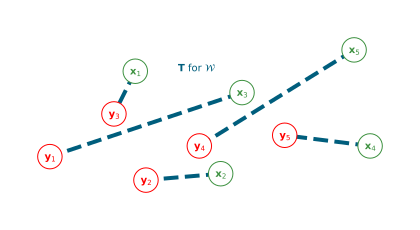

In [8]:
plot_optimal_transport_graph(xs, ys, T=T_W, T_title='$\mathbf{T}$ for $\mathcal{W}$')

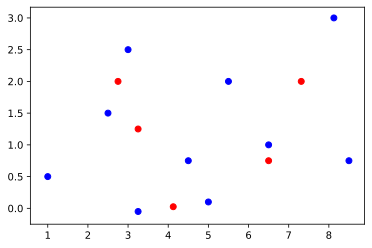

In [9]:
# blue are the data points
plt.scatter(xs[:,0], xs[:,1], c = "blue")
plt.scatter(ys[:,0], ys[:,1], c = "blue")

# red are the barycenter points, as computed by the algorithm
plt.scatter(x[:,0], x[:,1], c = "red")

In [10]:
xs[:,0]

array([3.   , 5.   , 5.5  , 8.5  , 8.125])

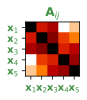

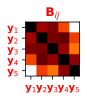

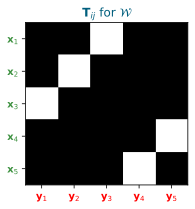

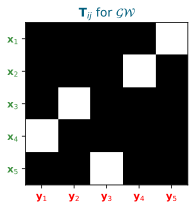

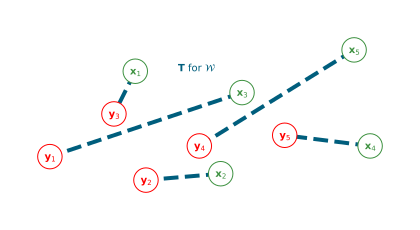

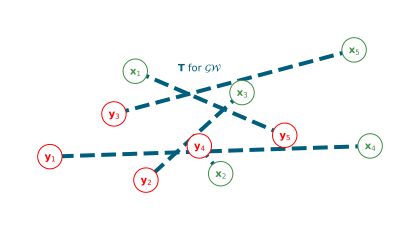

In [11]:
# PLOTS ########################################################################

if PLOT_TEXT:
    xs_labels = ['$\mathbf{x}_' + str(i + 1) + '$' for i in range(n_xs)]
    ys_labels = ['$\mathbf{y}_' + str(i + 1) + '$' for i in range(n_ys)]
else:
    xs_labels = ['' for i in range(n_xs)]
    ys_labels = ['' for i in range(n_ys)]

plt.figure(figsize=(1,1))
plt.imshow(A, cmap=cm.gist_heat, interpolation='nearest')
if PLOT_TEXT:
    plt.title('$\mathbf{A}_{ij}$', color=X_COLOR)
plt.xticks(np.arange(n_xs), xs_labels, color=X_COLOR)
plt.yticks(np.arange(n_xs), xs_labels, color=X_COLOR)

plt.figure(figsize=(1,1))
if PLOT_TEXT:
    plt.title('$\mathbf{B}_{ij}$', color=Y_COLOR) 
plt.imshow(B, cmap=cm.gist_heat, interpolation='nearest')
plt.xticks(np.arange(n_ys), ys_labels, color=Y_COLOR)
plt.yticks(np.arange(n_ys), ys_labels, color=Y_COLOR)
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(T_W, cmap=cm.gist_heat, interpolation='nearest')
if PLOT_TEXT:
    plt.title('$\mathbf{T}_{ij}$ for $\mathcal{W}$', color=T_COLOR)
plt.yticks(np.arange(n_xs), xs_labels, color=X_COLOR)
plt.xticks(np.arange(n_ys), ys_labels, color=Y_COLOR)
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(T_GW, cmap=cm.gist_heat, interpolation='nearest')
if PLOT_TEXT:
    plt.title('$\mathbf{T}_{ij}$ for $\mathcal{GW}$', color=T_COLOR)
plt.yticks(np.arange(n_xs), xs_labels, color=X_COLOR)
plt.xticks(np.arange(n_ys), ys_labels, color=Y_COLOR)
plt.show()

plot_optimal_transport_graph(xs, ys, T=T_W,
                             T_title='$\mathbf{T}$ for $\mathcal{W}$')

plot_optimal_transport_graph(xs, ys, T=T_GW,
                             T_title='$\mathbf{T}$ for $\mathcal{GW}$')